# **Ansatz Circuit Configuration Testbench - Quantum Machine Learning Capstone 2022**

#### **Capstone Members ⸻** Carson Darling, Brandon Downs, Christopher Haddox, Brightan Hsu, Matthew Jurenka

#### **Sponsor ⸻** Dr. Gennaro De Luca

<br>


The purpose of this Jupyter Notebook is to serve as a testbench for the quantum machine learning capstone group. This testbench allows for the testing of a quantum variational classifier with different ansatz configurations over different datasets.

Each circuit is a parameterized layered ansatz circuit that has been implemented to dynamically scale to an even number of qubits. The datasets are as follows:

&emsp;&emsp;[Iris Dataset](https://archive.ics.uci.edu/ml/datasets/iris) ⸻ 3 classes, 4 features of 150 plant measures. Each class refers to a type of iris plant, truncated to only 2 classes.

&emsp;&emsp;[Banknote Dataset](https://archive.ics.uci.edu/ml/datasets/banknote+authentication)⸻ 2 classes, 4 features of 1372 banknote-like specimen. Each class refers to forgery or authenticate.

&emsp;&emsp;[Transfusion Dataset](https://archive.ics.uci.edu/ml/datasets/Blood+Transfusion+Service+Center) ⸻ 2 classes, 4 features of 748 donors from the donor database. Each class refers to donation in March 2007.

&emsp;&emsp;[Vertebral Column Dataset](https://archive.ics.uci.edu/ml/datasets/Vertebral+Column) ⸻ 2 classes, 6 features of 310 vertebral columns from orthopaedic patients. Each class refers to abnormal or normal.

&emsp;&emsp;[Wheat Seeds Dataset](https://archive.ics.uci.edu/ml/datasets/seeds) ⸻ 3 classes, 7 features of 210 wheat seeds. Truncated to 6 features based on feature importance and 2 classes for binary classification. Each class refers to a different wheat seed type.

&emsp;&emsp;[Pima Indians Diabetes Dataset](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database) ⸻ 2 classes, 8 features of 768 patients with potential diabetes. Each class refers whether or not the patient has diabetes.

&emsp;&emsp;[Water Potability Databset](https://www.kaggle.com/datasets/adityakadiwal/water-potability) ⸻ 2 classes, 9 features of 2011 samples of water. Samples with missing features were excluded. Truncated to 8 features based on feature importance. Each class refers to whether or not the water is drinkable.

&emsp;&emsp;[Synthetic Datasets]() ⸻ 2 classes consisting of any number of features and instances for testing purposes.
<br>

### Imports

In [23]:
import subprocess
import sys

def pip_install(package):
    subprocess.run([sys.executable, "-m", "pip", "install", package])

def clean_install():
    [pip_install(package)
     for package in ['tqdm', 'sklearn', 'pennylane', 'pandas', 'pennylane-qiskit', 'pylatexenc', 'matplotlib', 'qiskit', 'qiskit-machine-learning']]

#clean_install()

In [24]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np
from sklearn.model_selection import train_test_split
from qiskit.utils import algorithm_globals
from tqdm.notebook import tqdm_notebook
from pennylane import numpy as np
import pennylane as qml
import random as rand
import time as time
import pandas as pd
import os as os
import math

### The VQC

In [25]:
# @Param optimizer: an optimizer string of the order adam, gd, nm, or other
# @Param step_size: the learning rate for the optimizer
# @Return a pennylane optimizer
def generate_optimizer(optimizer, step_size):
    if optimizer == 'adam': return qml.optimize.AdamOptimizer(step_size)
    elif optimizer == 'nm': return qml.optimize.NesterovMomentumOptimizer(step_size)
    else: return qml.optimize.AdagradOptimizer(step_size)

# @Param labels - the y test values for the current dataset
# @Param predictions - the y train values from the model
# @Return a calculation of the square loss/error
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return np.mean(np.array(loss))

# @Param labels - the y test values for the current dataset
# @Param predictions = the y train values from the model
# @Return the correctness of the model as a percentage
def accuracy(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

# @Param weights - the weight array as updated during the training
# @Param bias - the bias array as updated during the training
# @Param features - the x train data for the dataset
# @Param test - an ANSATZ_CIRCUIT_TEST object
# @Return - a QNode Circuit result
def variational_classifier(weights, bias, features, test):
    return test.circuit(test.num_qubits, weights, features) + bias

# @Param weights - the weight array as updated during the training
# @Param bias - the bias array as updated during the training
# @Param features - the x train data for the dataset
# @Param test - an ANSATZ_CIRCUIT_TEST object
# @Return - the total square loss for all the rows in the dataset
def cost(weights, bias, features, labels, test):
    predictions = [variational_classifier(weights, bias, f, test) for f in features]
    return square_loss(labels, predictions)

# Print the Header for the running classifier
header_template = '\t{:<7}   {:<7}   {:<16}   {:<15}'
def print_header():
    print(header_template.replace(':', ':-').format('', '', '', ''))
    print(header_template.format(
        *['Epoch', 'Cost', 'Train_Accuracy', 'Test_Accuracy']))
    print(header_template.replace(':', ':-').format('', '', '', ''))

# @Param dataset - the 4-tuple containing the initial biases, weights, features, and labels
# @Param optimizer - the optimizer string
# @Param results_dataframe -the Pandas dataframe for the given circuit-optimizer
# @Param test - an ANSATZ_CIRCUIT_TEST object
def train_classifier(dataset, optimizer, test):

    opt = generate_optimizer(optimizer, .1)
    batch_size = 5
    weights, bias, features, labels = dataset

    max_cost = max_train = max_test = 0

    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=0.25, random_state=rand.randint(0, 100))

    test.curr.update(untrained_weights=weights)
    for epoch_index in range(100):
        if not epoch_index:
            print_header()

        # Update the weights by one optimizer step
        batch_index = np.random.randint(0, len(X_train), (batch_size,))

        X_train_batch = X_train[batch_index]
        y_train_batch = y_train[batch_index]
        weights, bias, _, _, _ = opt.step(
            cost, weights, bias, X_train_batch, y_train_batch, test)

        # Compute predictions on train and validation set
        predictions_train = [np.sign(variational_classifier(
            weights, bias, value, test)) for value in X_train]
        predictions_test = [np.sign(variational_classifier(
            weights, bias, value, test)) for value in X_test]

        # Compute accuracy on train and validation set
        train_acc = accuracy(y_train, predictions_train)
        test_acc = accuracy(y_test, predictions_test)
        epoch_cost = cost(weights, bias, features, labels, test)

        # Update the results dataframe
        test.curr.update(epoch=epoch_index, cost=epoch_cost,train_acc=train_acc, test_acc=test_acc, trained_weights=weights, shape=features.shape, optimizer=optimizer)
        test.curr.write()

        # Tabulate a summary of the current epoch
        print(header_template.format(*[f'{epoch_index:4d}', f'{epoch_cost:0.3f}',
            f'{train_acc:0.7f}', f'{test_acc:0.7f}']))

### Ansatz Circuit Library

#### Circuit Printing Function

In [26]:
def draw_circuit_mpl(circuit, num_qubits):
    draw_device = qml.device("qiskit.aer", wires=num_qubits)
    temp_circuit = qml.QNode(circuit, draw_device)
    draw_weight_shape = qml.templates.StronglyEntanglingLayers.shape(n_layers=1, n_wires=num_qubits)
    draw_weights = np.random.random(draw_weight_shape)
    draw_features = [0] * num_qubits
    fig = qml.draw_mpl(temp_circuit)(num_qubits, draw_weights, draw_features)


### [Pennylane Layered Circuit](https://pennylane.ai/qml/demos/tutorial_variational_classifier.html)

The Pennylane Layered Circuit from their Variational Quantum Classifier demo uses a series of single rotation gates on each wire. Finally, it entangles in a circular pattern where the control is a given qubit and the target the successor modulus the number of qubits.

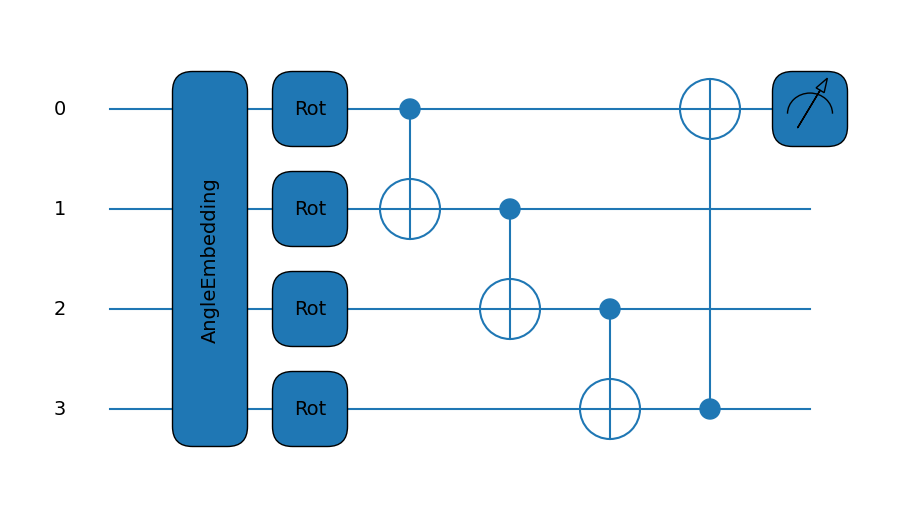

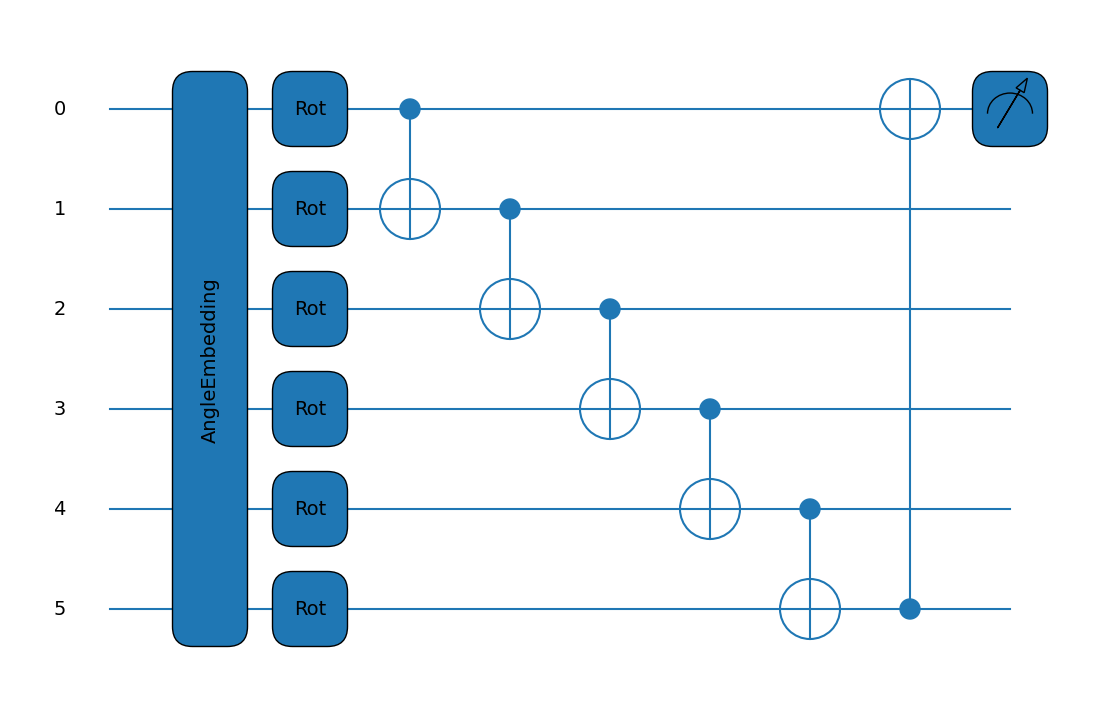

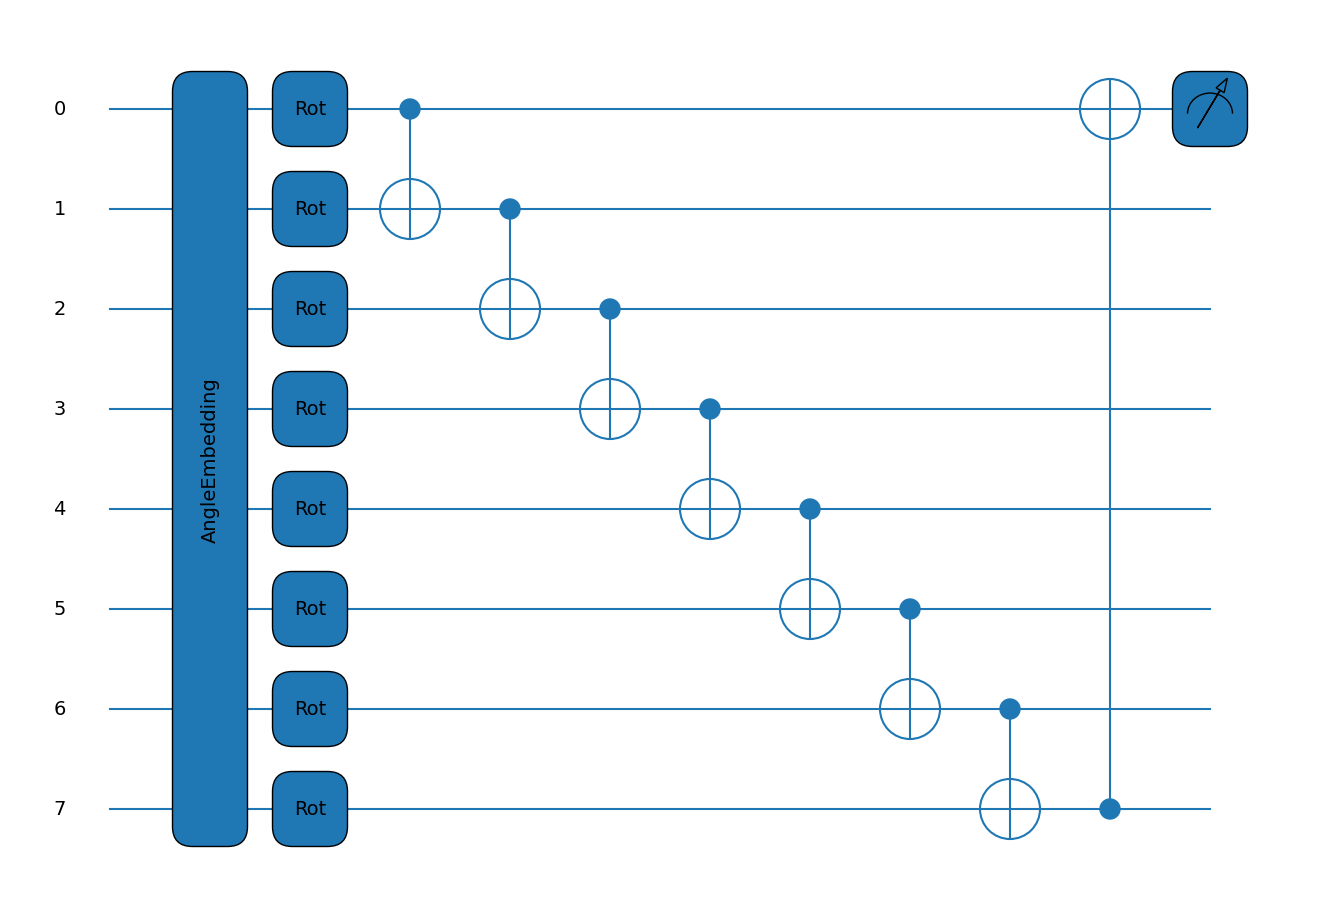

In [27]:
def Layered(*args):
    num_qubits, weights, features = args

    qml.AngleEmbedding(features, wires=range(num_qubits), rotation="Y")

    for W in weights:
        for qubit in range(num_qubits):
            qml.Rot(W[qubit,0], W[qubit, 1], W[qubit, 2], wires=qubit)

        for qubit in range(num_qubits):
            qml.CNOT(wires=[qubit, (qubit+1) % num_qubits])

    return qml.expval(qml.PauliZ(0))

draw_circuit_mpl(Layered, 4)
draw_circuit_mpl(Layered, 6)
draw_circuit_mpl(Layered, 8)

#### [Pairwise Controlled Rotation Circuit](https://arxiv.org/pdf/1612.02806.pdf)

The pairwise controlled rotation circuit from the 2017 ***[Quantum Autoencoders for efficient compression of quantum data](https://arxiv.org/pdf/1612.02806.pdf)*** utilizes exactly the name: continuous pairs of controlled rotation gates where the control is a given qubit and the target all possible other qubits. Prefixed and suffixed with single qubit rotation gates, there is a comprehensive amount of entanglement between wires. This forms a sections of entanglement of each wire to its peers in the order of n sections of n-1 wires.

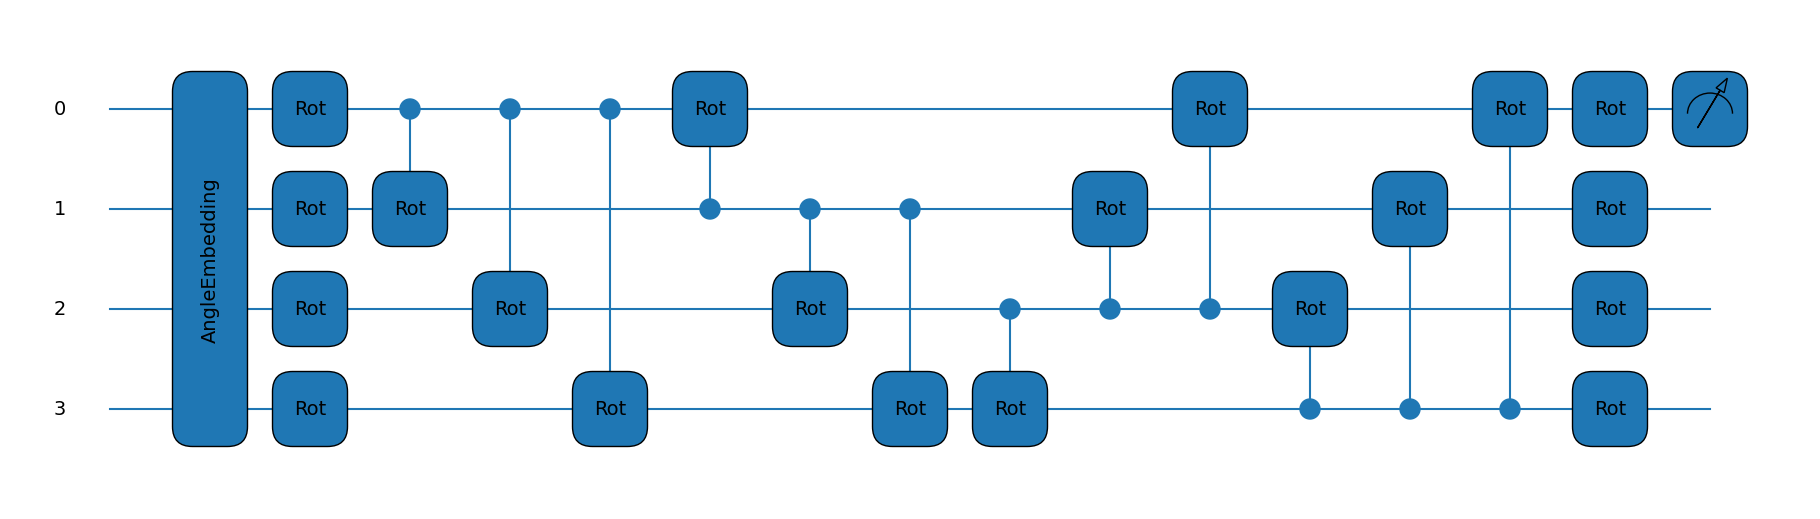

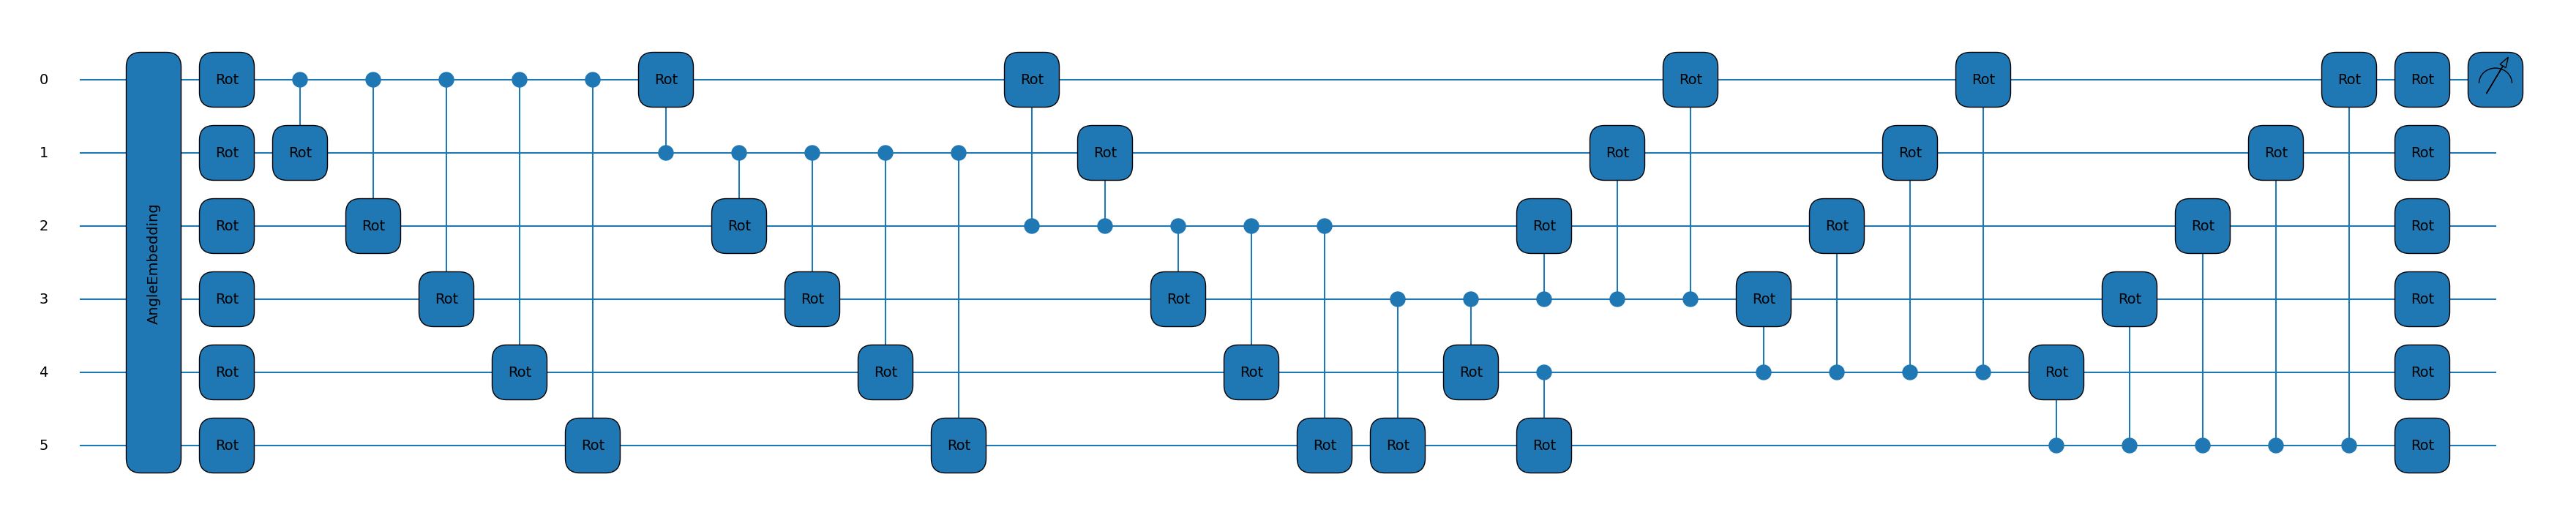

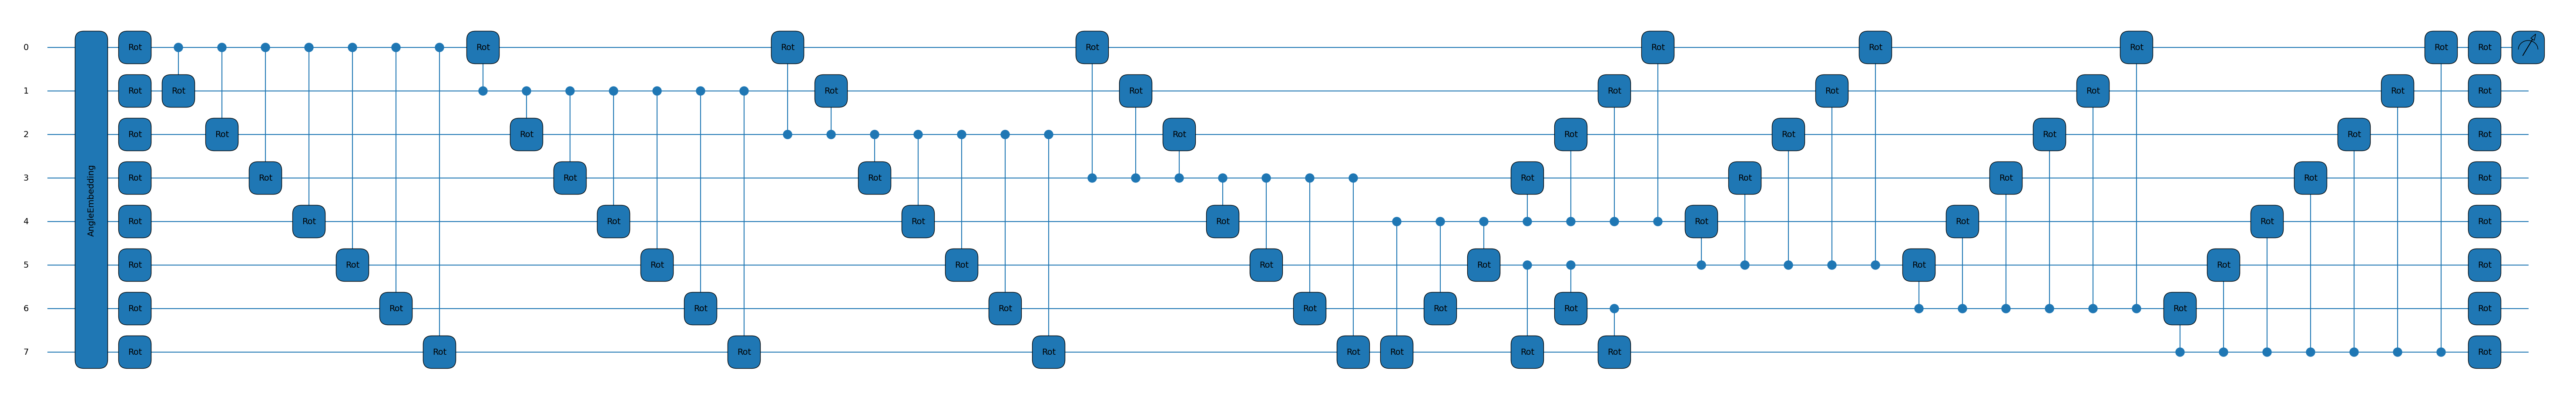

In [28]:
def PairwiseCRot(*args):
    num_qubits, weights, features = args

    qml.AngleEmbedding(features, wires=range(num_qubits), rotation="Y")

    for W in weights:

        for qubit in range(num_qubits):
            qml.Rot(W[qubit,0],W[qubit, 1], W[qubit, 2], wires=qubit)

        for outer_qubit in range(num_qubits):

            valid_pairs = list(range(num_qubits))
            valid_pairs.remove(outer_qubit)

            if num_qubits / 2 <= outer_qubit:
                valid_pairs.reverse()

            for inner_qubit in valid_pairs:
                qml.CRot(W[outer_qubit,0], W[outer_qubit, 1], W[outer_qubit, 2], wires=[outer_qubit, inner_qubit])


        for qubit in range(num_qubits):
            qml.Rot(W[qubit,0], W[qubit, 1], W[qubit, 2], wires=qubit)

    return qml.expval(qml.PauliZ(0))

draw_circuit_mpl(PairwiseCRot, 4)
draw_circuit_mpl(PairwiseCRot, 6)
draw_circuit_mpl(PairwiseCRot, 8)

#### [A and B Parameterization Circuit](https://pennylane.ai/qml/glossary/circuit_ansatz.html#a-parametrized-b-parametrized)
A novel AB parameterization circuit

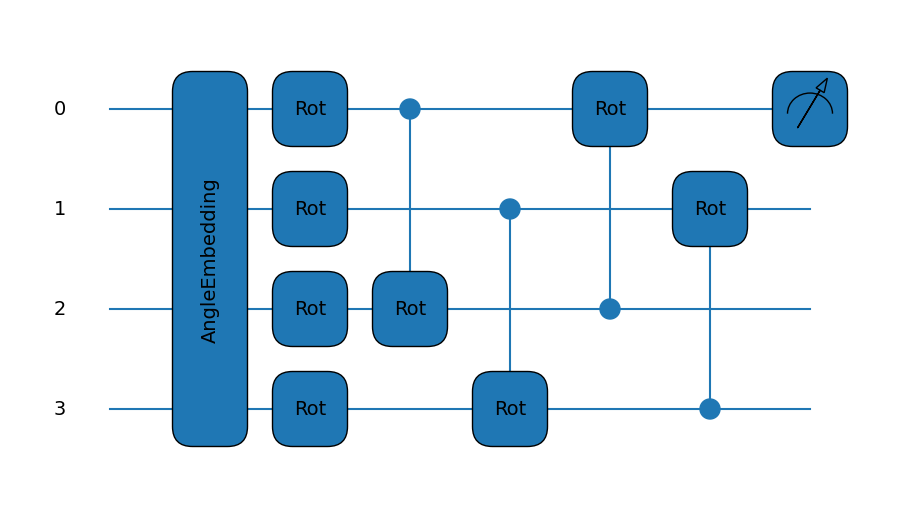

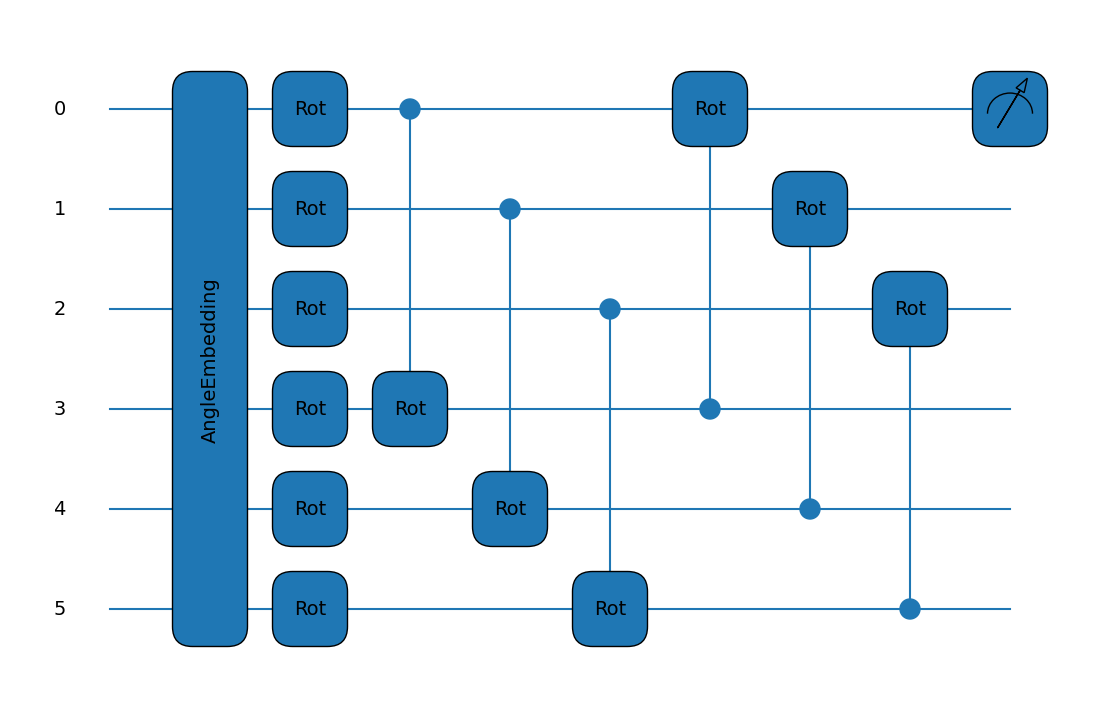

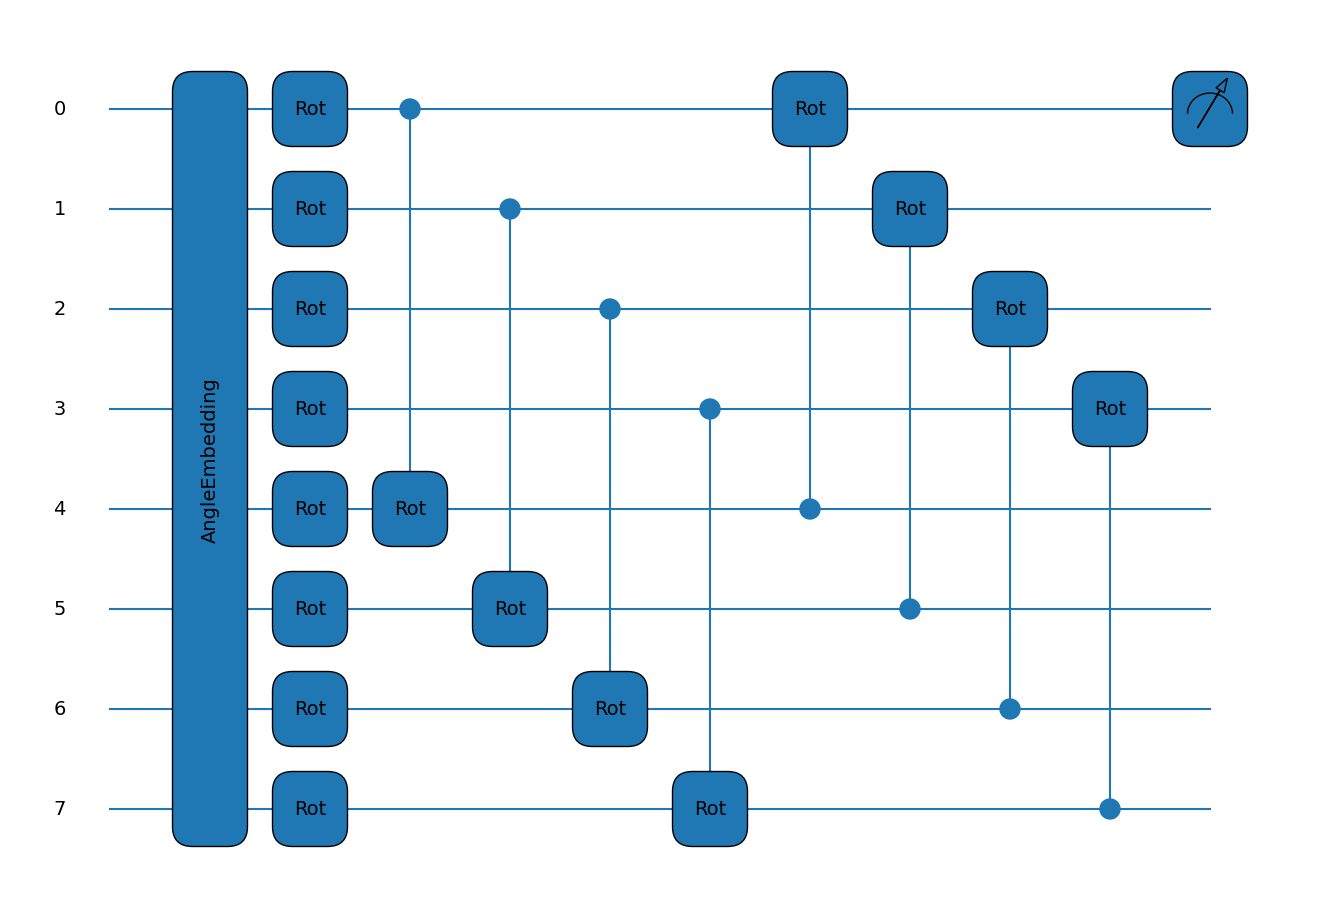

In [29]:
def ParameterizedAB(*args):
    num_qubits, weights, features = args
    qml.AngleEmbedding(features, wires=range(num_qubits), rotation="Y")


    for W in weights:
        for qubit in range(num_qubits):
            qml.Rot(W[qubit,0],W[qubit, 1], W[qubit, 2], wires=qubit)

        for qubit in range(num_qubits):
            qml.CRot(W[qubit,0], W[qubit, 1], W[qubit, 2], wires=[qubit, (num_qubits/2 + qubit) % num_qubits])

    return qml.expval(qml.PauliZ(0))
draw_circuit_mpl(ParameterizedAB, 4)
draw_circuit_mpl(ParameterizedAB, 6)
draw_circuit_mpl(ParameterizedAB, 8)

#### [Strong Entanglement Circuit](https://arxiv.org/pdf/1804.00633.pdf)
Utilizing a generic model circuit architecture for strongly entangled wires, the blocks are parameterized in an A and B subsection similar to the AB parameterization. Utilizing a modulus function involving the range of the operations of specific gates, a greatly entangled circuit is generated. The paper goes in depth with optimizations of this generic strongly entangled AB parameterization ansatz circuit regarding global phases and phase gates. For the purposes of this study, the generic circuit architecture is being used with rotation gates as the single qubit gates and controlled not gates as the entanglement gates.

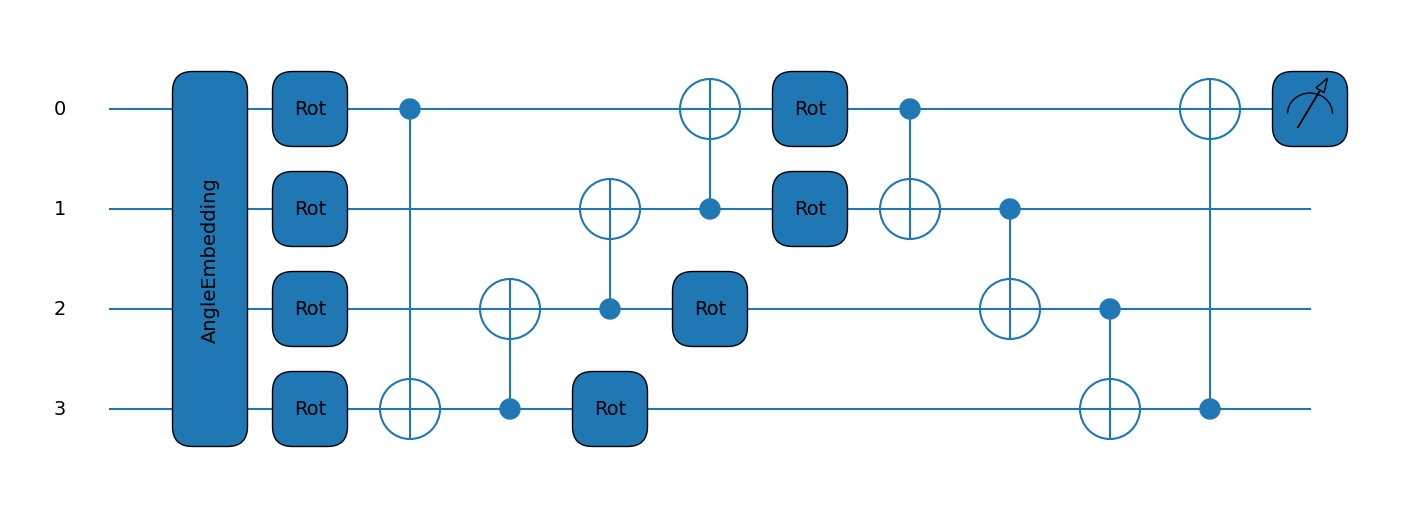

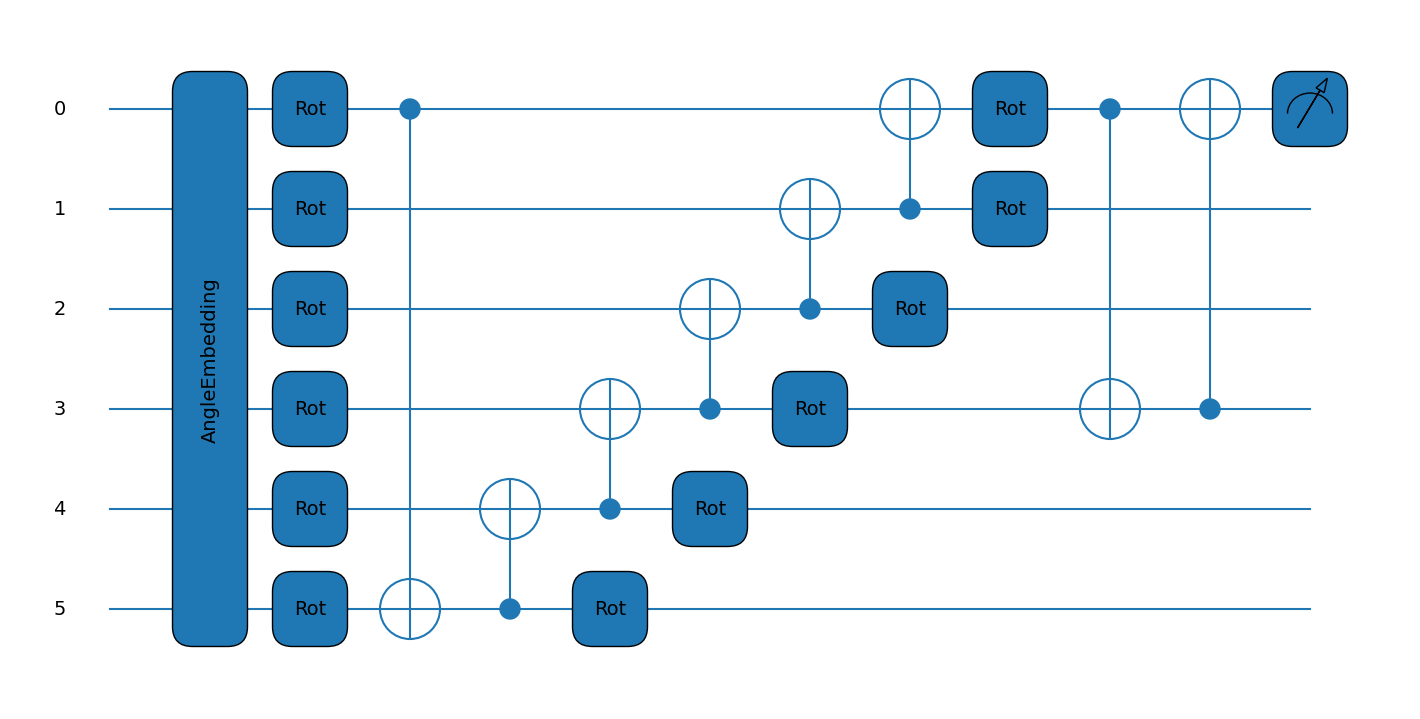

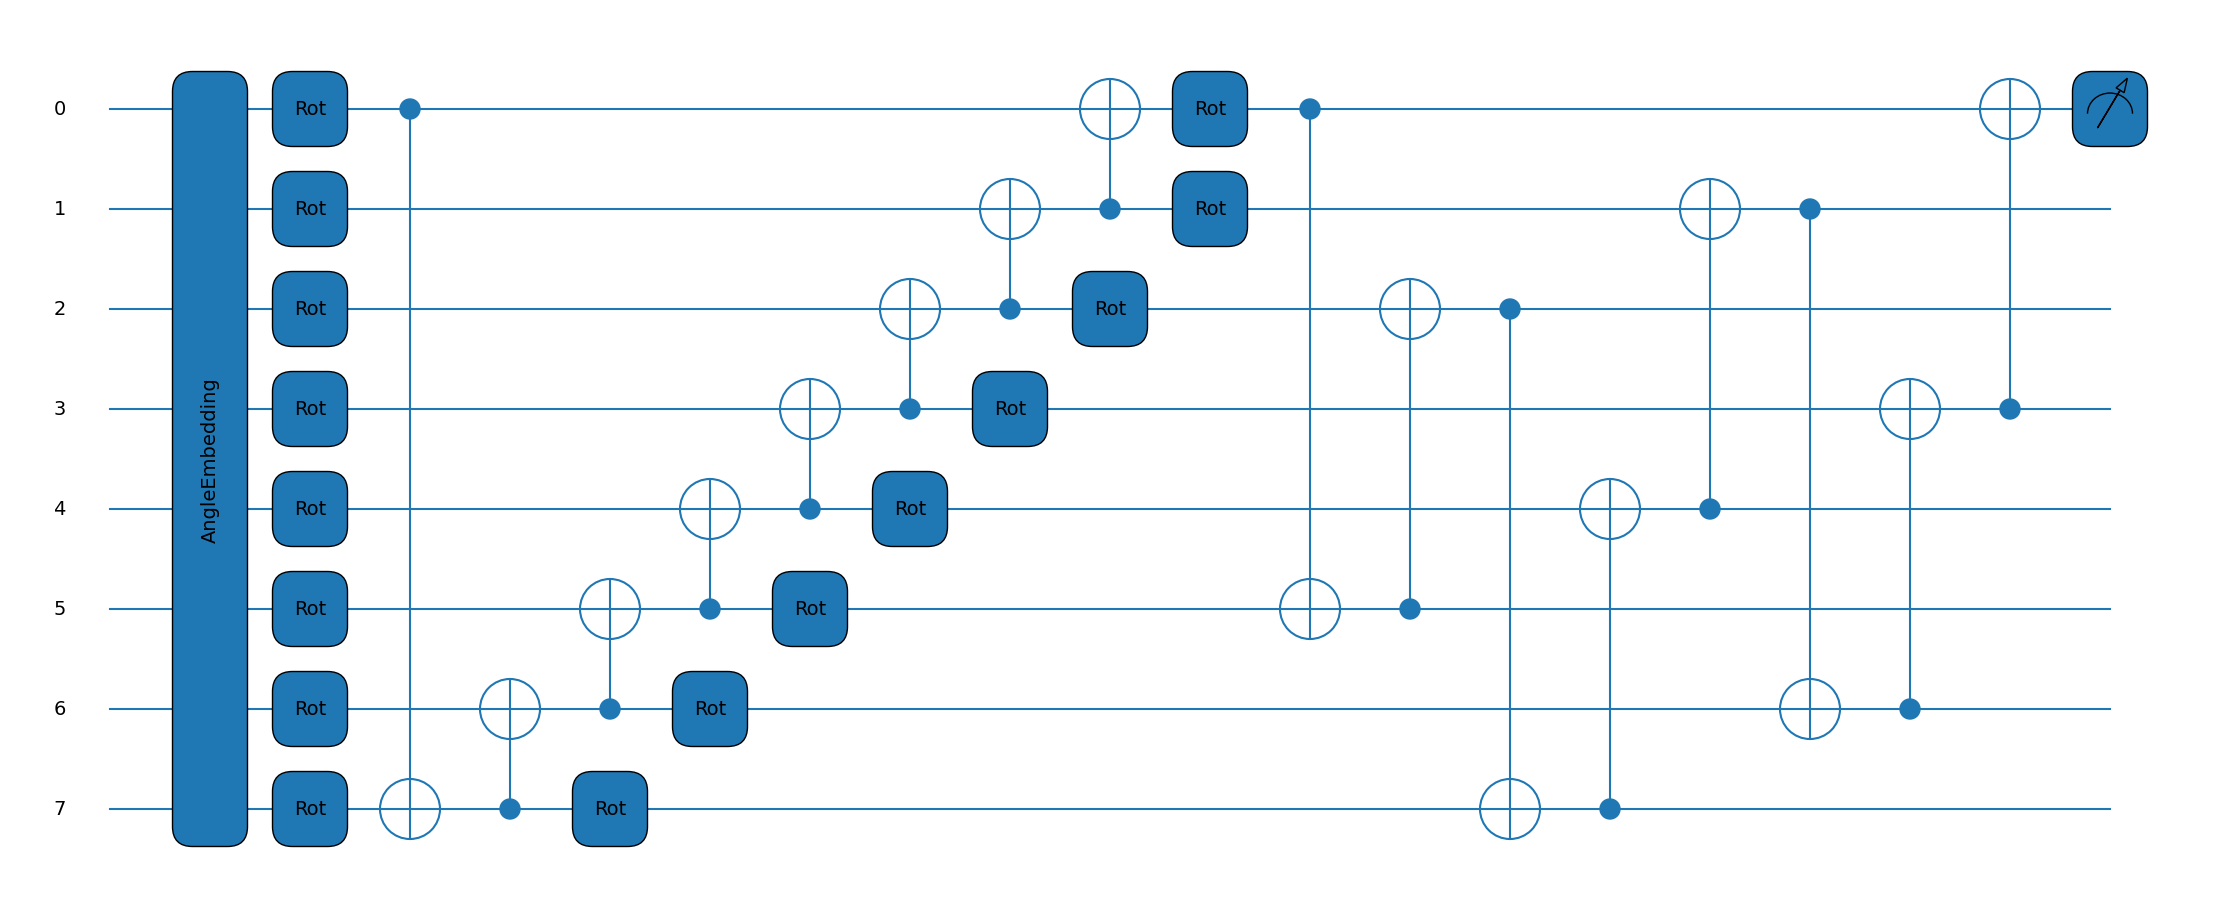

In [30]:
def StronglyEntangled(*args):
    num_qubits, weights, features = args
    qml.AngleEmbedding(features, wires=range(num_qubits), rotation="Y")

    for W in weights:
        for r in [1, 3]:
            for qubit in range(num_qubits):
                qml.Rot(W[qubit,0], W[qubit, 1], W[qubit, 2], wires=qubit)

            for j in reversed(range(1, int(num_qubits / math.gcd(num_qubits, r))+1)):
                qubit_target = ((j * r) - r) % num_qubits
                qubit_control = (j * r) % num_qubits
                qml.CNOT(wires=[qubit_control, qubit_target])

    return qml.expval(qml.PauliZ(0))
draw_circuit_mpl(StronglyEntangled, 4)
draw_circuit_mpl(StronglyEntangled, 6)
draw_circuit_mpl(StronglyEntangled, 8)

### [Hardware Efficient Circuit](https://www.nature.com/articles/nature23879)


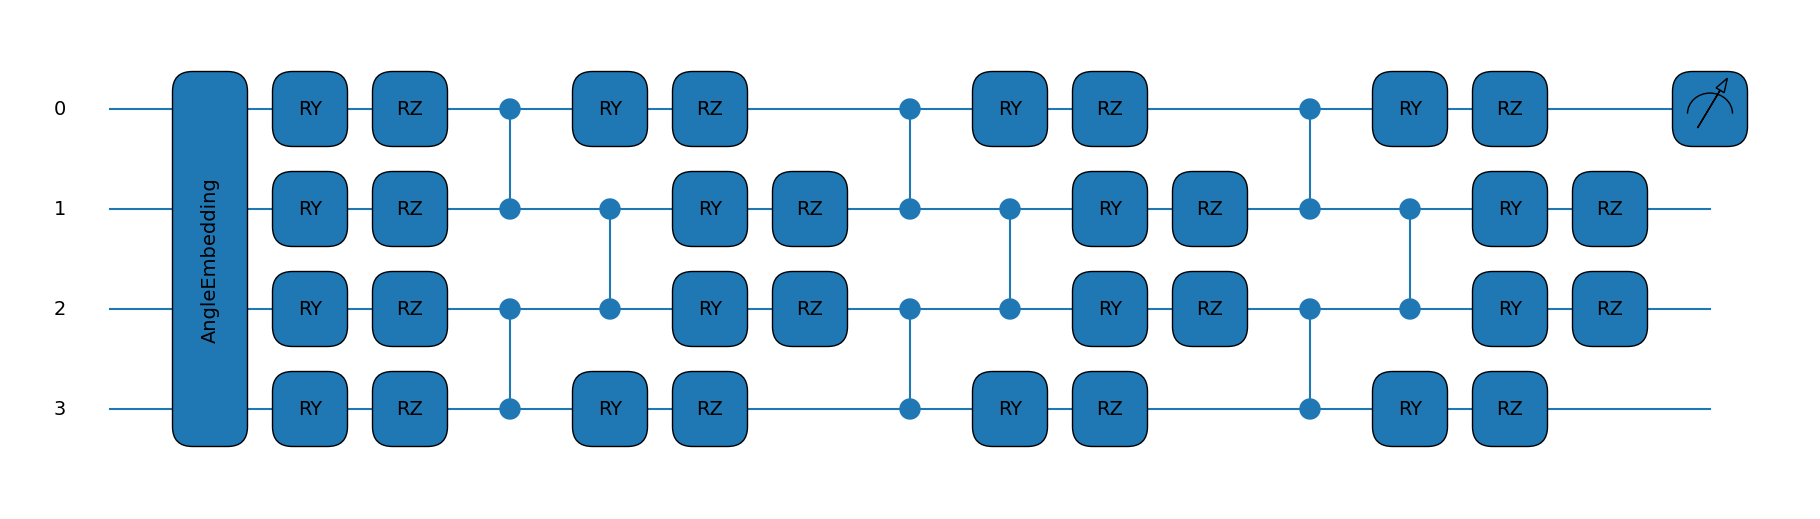

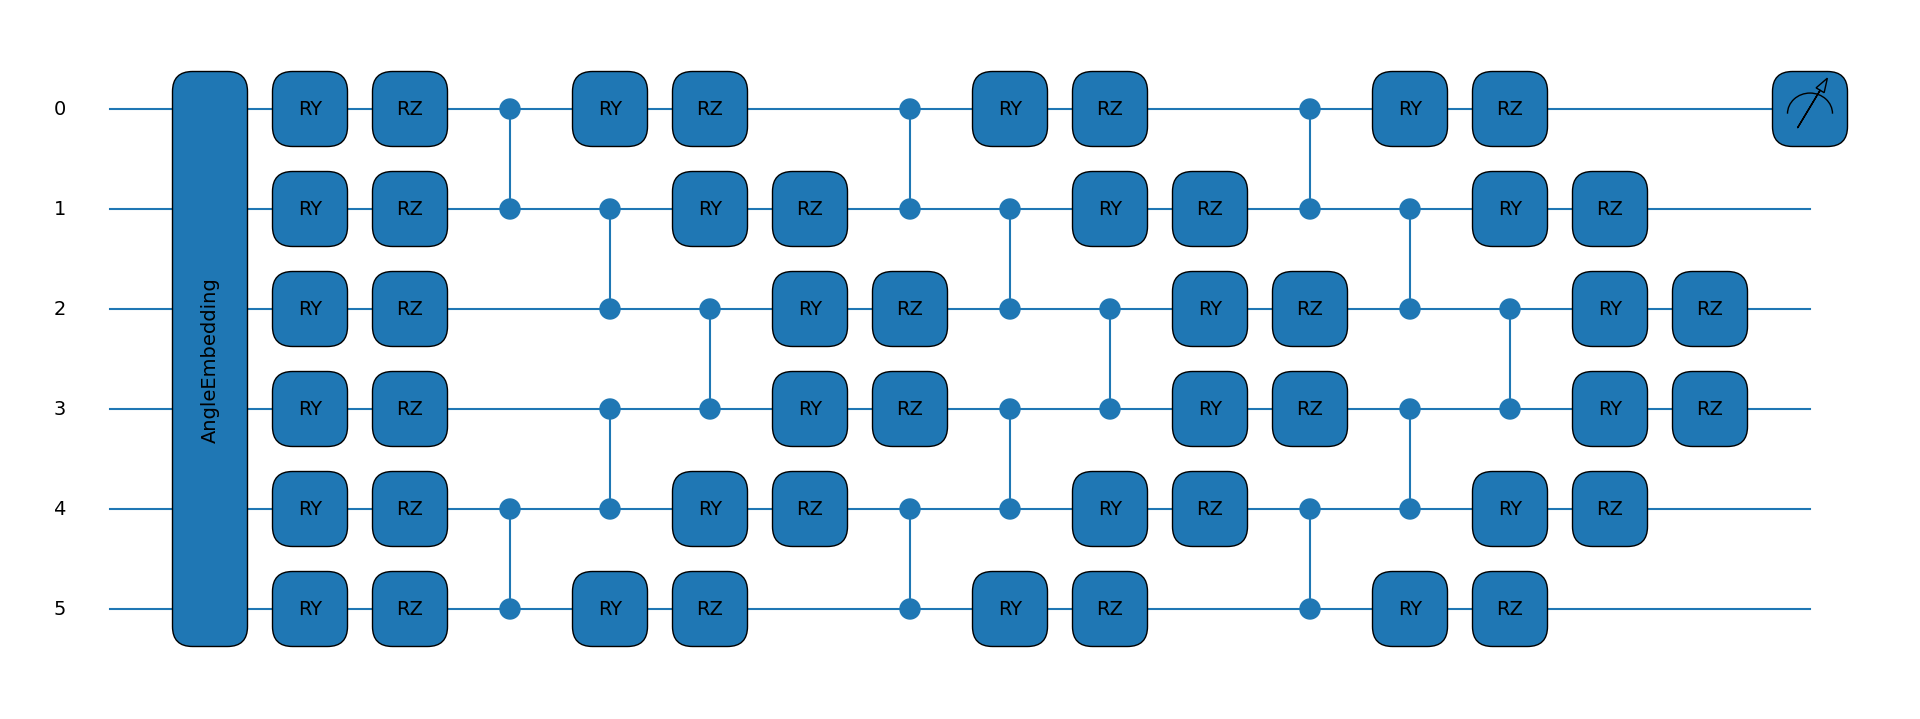

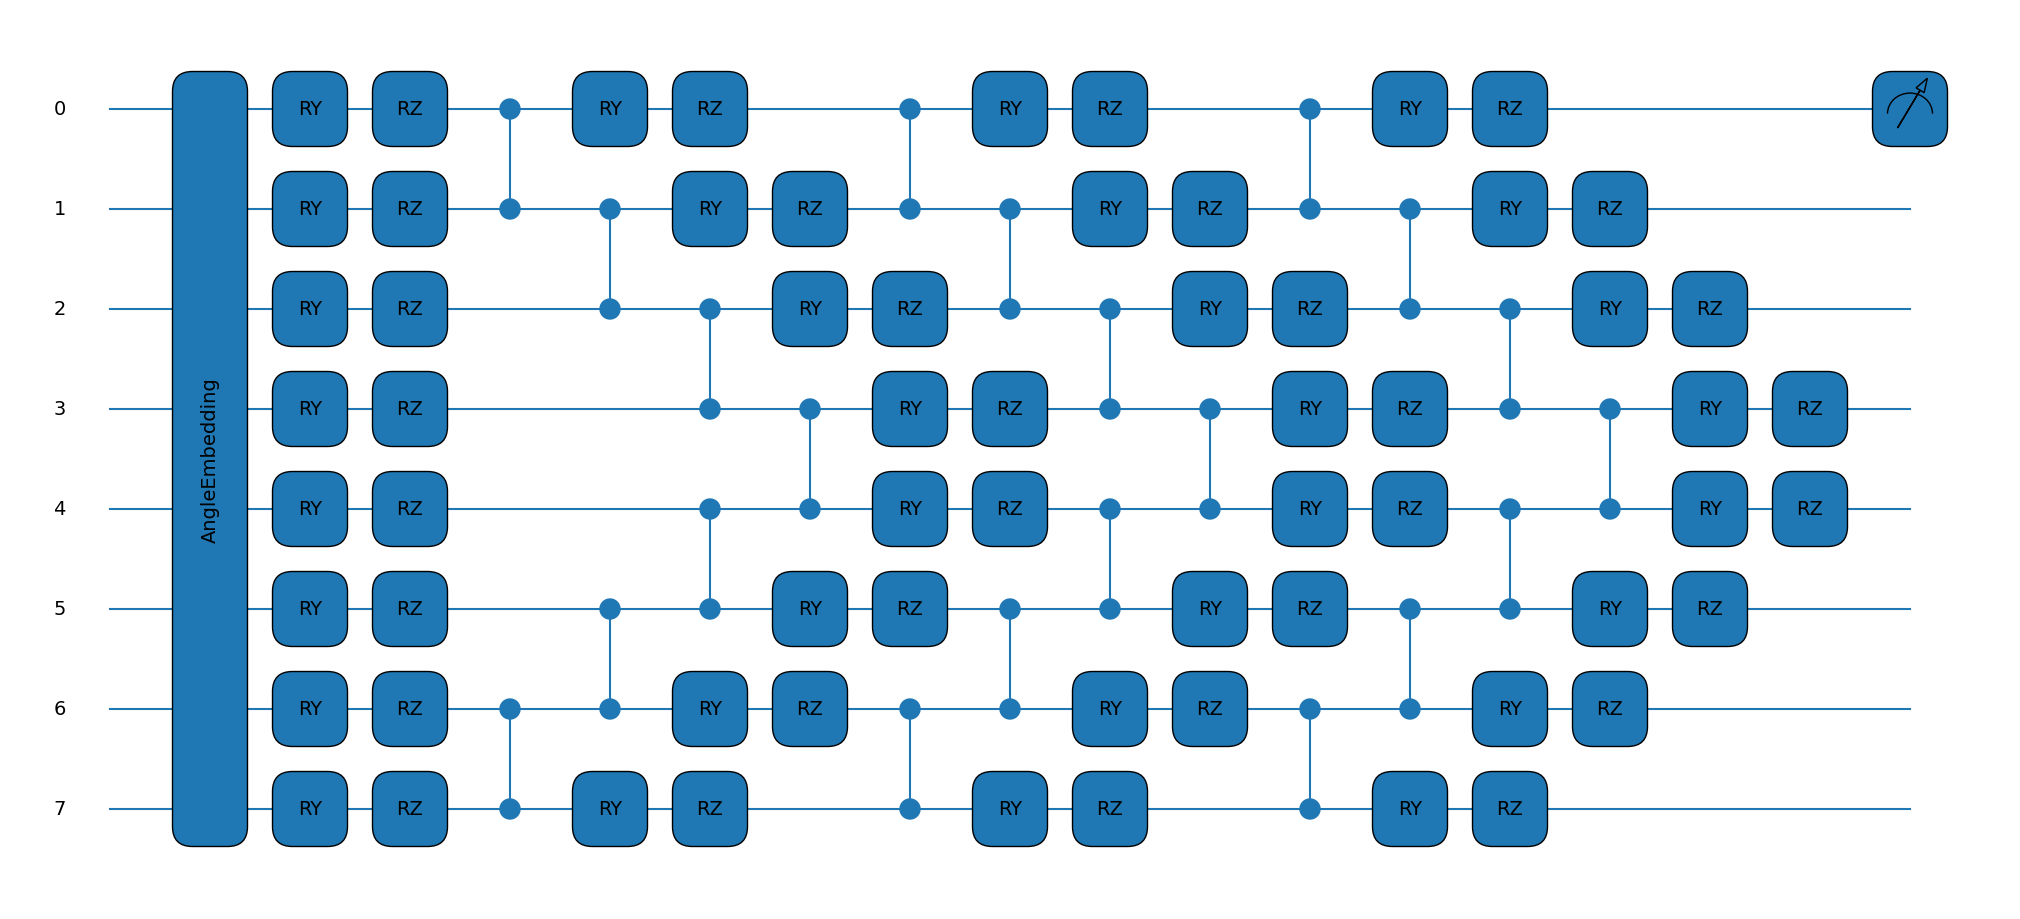

In [31]:
def HardwareEfficient(*args):
    num_qubits, weights, features = args
    depth = 3
    qml.AngleEmbedding(features, wires=range(num_qubits), rotation="Y")

    for W in weights:

        for d in range(depth):
            for qubit in range(num_qubits):
                qml.RY(W[qubit, 0], wires=qubit)
                qml.RZ(W[qubit, 0], wires=qubit)

            for qubit in range(int(num_qubits/2)):
                p1 = [qubit, qubit+1]
                p2 = [num_qubits-qubit-1, num_qubits-qubit-2]
                qml.CZ(wires=p1)
                qml.CZ(wires=p2) if set(p1) != set(p2) else None

        for qubit in range(num_qubits):
            qml.RY(W[qubit, 0], wires=qubit)
            qml.RZ(W[qubit, 0], wires=qubit)

    return qml.expval(qml.PauliZ(0))
draw_circuit_mpl(HardwareEfficient, 4)
draw_circuit_mpl(HardwareEfficient, 6)
draw_circuit_mpl(HardwareEfficient, 8)

### Data Generation, Parsing, and Preprocessing

In [32]:
def generate_synthetic_data(num_samples, num_features):
    X = algorithm_globals.random.normal(0, 0.5, size=(num_samples, num_features))
    y01 = 1 * (np.sum(X, axis=1) >= 0)
    y = 2 * y01 - 1    
    return X,y

In [33]:
def preprocess(df, samples, num_features):
    # Set the first unique target to -1, the second unique target to 1
    try:
        df.target = df.target.map(
            {df.target.unique()[1]: -1, df.target.unique()[2]: 1})
    except IndexError:
        df.target = df.target.map(
            {df.target.unique()[0]: -1, df.target.unique()[1]: 1})

    # Undersample datasets down to 100 samples
    try:
        df = pd.concat([
            df[(df.target == -1)].sample(n=samples, replace=False,
                                         random_state=rand.randint(0, 100)),
            df[(df.target == 1)].sample(n=samples, replace=False,
                                        random_state=rand.randint(0, 100))])
    # Otherwise take the sample as is
    except ValueError:
        pass
    # Remove any ternary or above targets
    finally:
        df = df[(df.target == -1) | (df.target == 1)]


    # Split data to features, labels
    # Min-Max normalize the features and represent as angles (2pi)
    X = np.array(df)[:, 0:num_features]
    features = 2 * np.pi * (X - np.min(X)) / (np.max(X) - np.min(X))
    labels = np.array(df)[:, -1]

    return features, labels


# Traditional Datasets
iris_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
banknote_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt'
transfusion_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/blood-transfusion/transfusion.data'
vertebral_column_path = 'https://raw.githubusercontent.com/mattjurenka/qml-capstone/main/data/vertebral_column.data'
seeds_path = 'https://raw.githubusercontent.com/mattjurenka/qml-capstone/main/data/seeds.data'
diabetes_path = 'https://raw.githubusercontent.com/mattjurenka/qml-capstone/main/data/diabetes.data'
water_path = 'https://raw.githubusercontent.com/mattjurenka/qml-capstone/main/data/water_potability.data'

# Set column names for preprocessing ease and read in the files from the URLs. Tranfusion has a header so drop it
column_names = ['a0', 'a1', 'a2', 'a3', 'target']
iris_df = pd.read_csv(iris_path, names=column_names)
banknote_df = pd.read_csv(banknote_path, names=column_names)
transfusion_df = pd.read_csv(transfusion_path, names=column_names, skiprows=1)

column_names = ['a0', 'a1', 'a2', 'a3', 'a4', 'a5', 'target']
vertebral_column_df = pd.read_csv(vertebral_column_path, names=column_names)
seeds_df = pd.read_csv(seeds_path, names=column_names)

column_names = ['a0', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'target']
diabetes_df = pd.read_csv(diabetes_path, names=column_names)
water_df = pd.read_csv(water_path, names=column_names)

# Make some weights, biases for the 4d datasets
init_bias = np.array(0.0, requires_grad=True)
init_weights_4d = 0.01 * np.random.randn(6, 4, 3, requires_grad=True)
init_weights_6d = 0.01 * np.random.randn(6, 6, 3, requires_grad=True)
init_weights_8d = 0.01 * np.random.randn(6, 8, 3, requires_grad=True)


In [34]:
Q4_datasets = {
    'iris': (init_weights_4d, init_bias, *preprocess(iris_df, 50, 4)),
    'transfusion': (init_weights_4d, init_bias, *preprocess(transfusion_df, 50, 4)),
    'banknote': (init_weights_4d, init_bias, *preprocess(banknote_df, 50, 4)),
    'synth': (init_weights_4d, init_bias, *generate_synthetic_data(50, 4)),
}

Q6_datasets = {
    'vertebral_column': (init_weights_6d, init_bias, *preprocess(vertebral_column_df, 50, 6)),
    'seeds': (init_weights_6d, init_bias, *preprocess(seeds_df, 50, 6)),
    'synth': (init_weights_6d, init_bias, *generate_synthetic_data(50, 6)),
}
# 6 variables continuous binary class
#above 1000

Q8_datasets = {
    'diabetes': (init_weights_8d, init_bias, *preprocess(diabetes_df, 50, 8)),
    'water': (init_weights_8d, init_bias, *preprocess(water_df, 50, 8)),
    'synth': (init_weights_8d, init_bias, *generate_synthetic_data(50, 8)),
}
# 8 variables continuous binary class
#above 1000

IndexError: index 1 is out of bounds for axis 0 with size 1

### Test Class and Results Class

In [ ]:
class CurrentResults():
    def __init__(self):
        self.df = pd.DataFrame(columns=['optimizer', 'circuit', 'dataset', 'iteration', 'epoch', 'cost', 'train_acc', 'test_acc', 'trained_weights', 'untrained_weights', 'shape'])
        self.optimizer = self.circuit = self.iteration = self.dataset = self.epoch = self.cost = self.train_acc = self.test_acc = trained_weights = untrained_weights = shape = None

    def update(self, optimizer=None, circuit=None, iteration=None, dataset=None, epoch=None, cost=None, train_acc=None, test_acc=None, trained_weights=None, untrained_weights=None, shape=None):
        if optimizer is not None: self.optimizer = optimizer
        if circuit is not None: self.circuit = circuit
        if iteration is not None: self.iteration = iteration
        if dataset is not None: self.dataset = dataset
        if epoch is not None: self.epoch = epoch
        if cost is not None: self.cost = cost
        if train_acc is not None: self.train_acc = train_acc
        if test_acc is not None: self.test_acc = test_acc
        if trained_weights is not None: self.trained_weights = trained_weights
        if untrained_weights is not None: self.untrained_weights = untrained_weights
        if shape is not None: self.shape = shape

    def format_results(self):
        return {'optimizer':self.optimizer, 'circuit':self.circuit,'dataset':self.dataset, 'iteration':self.iteration, 'epoch':self.epoch, 'cost':self.cost, 'train_acc':self.train_acc, 'test_acc':self.test_acc, 'trained_weights': self.trained_weights, 'untrained_weights': self.untrained_weights, 'shape': self.shape}

    def write(self):
        epoch_results = self.format_results()
        self.df = self.df.append(epoch_results, ignore_index=True)

class ANSATZ_CIRCUIT_TEST():
    def __init__(self, ansatz_type, num_qubits, num_iterations):
        self.device = self.circuit = self.ansatz = self.curr = None
        self.num_iterations = num_iterations
        self.num_qubits = num_qubits
        self.generate_ansatz(ansatz_type)

    def generate_ansatz(self, ansatz_type):
        self.device = qml.device("default.qubit", wires=self.num_qubits + 1)
        self.circuit_func = ansatz_type
        self.circuit =  qml.QNode(self.circuit_func, self.device)

    def write_results(self):
        out_directory = 'results'

        if not os.path.exists(out_directory):
            os.mkdir(out_directory)

        out_path = os.path.join(out_directory, f'{self.curr.circuit}-{self.curr.optimizer}')

        self.curr.df.to_csv(f'{out_path}.csv', index=False)

    def execute(self, datasets):
        # Generate Data
        for optimizer in ['adam', 'nm', 'adagrad']:
            self.curr = CurrentResults()

            for dataset_name, dataset in datasets.items():

                for iteration in range(self.num_iterations):
                    self.curr.update(circuit=self.circuit.__name__, dataset=dataset_name, iteration=iteration)
                    print(f'{self.circuit.__name__} | {optimizer} | {dataset_name} | {iteration+1} of {self.num_iterations}')
                    train_classifier(dataset, optimizer, self)
                    self.device.reset()

            self.write_results()


In [ ]:
a1 = ANSATZ_CIRCUIT_TEST(num_qubits=6,ansatz_type=Layered, num_iterations=3)
a1.execute(datasets=Q6_datasets)